In [145]:
import math

import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display
import numpy as np

In [146]:
tf.config.run_functions_eagerly(True)


In [147]:
PATH = '../'

In [148]:
BUFFER_SIZE = 2001

BATCH_SIZE = 1

IMG_WIDTH = 256
IMG_HEIGHT = 256

In [149]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    image = tf.reduce_max(image, axis=-1,keepdims=True)
    return image

In [150]:
train_dataset_1 = tf.data.Dataset.list_files(str(PATH + 'resources/data/class_test/Carattere-Regular/*.jpg'), shuffle=False)
train_dataset_1 = train_dataset_1.map(load,num_parallel_calls=tf.data.AUTOTUNE)
train_dataset_2 = tf.data.Dataset.list_files(str(PATH + 'resources/data/class_test/SingleDay-Regular/*.jpg'), shuffle=False)
train_dataset_2 = train_dataset_2.map(load,num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)

train_size = int(0.9 * train_dataset.cardinality().numpy())
test_dataset = train_dataset.skip(train_size)
train_dataset = train_dataset.take(train_size)

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

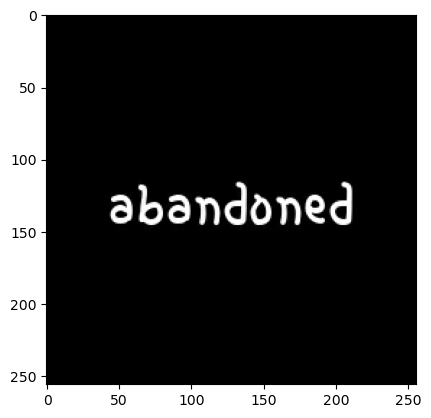

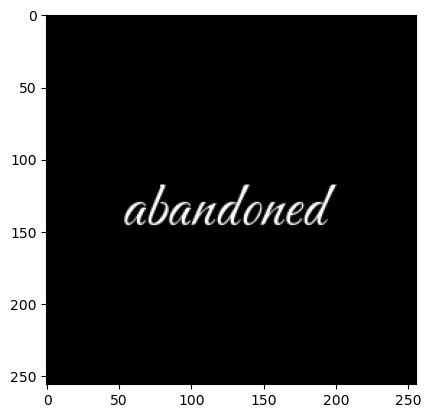

In [151]:

inp = load(str(PATH + 'resources/data/class_test/SingleDay-Regular/img_abandoned.jpg'))
re = load(str(PATH + 'resources/data/class_test/Carattere-Regular/img_abandoned.jpg'))
plt.figure()
plt.imshow(inp / 255.0, cmap='gray')
plt.figure()
plt.imshow(re / 255.0, cmap='gray')

In [152]:
OUTPUT_CHANNELS = 1

In [153]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [154]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [155]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [156]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [157]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, OUTPUT_CHANNELS])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 1)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

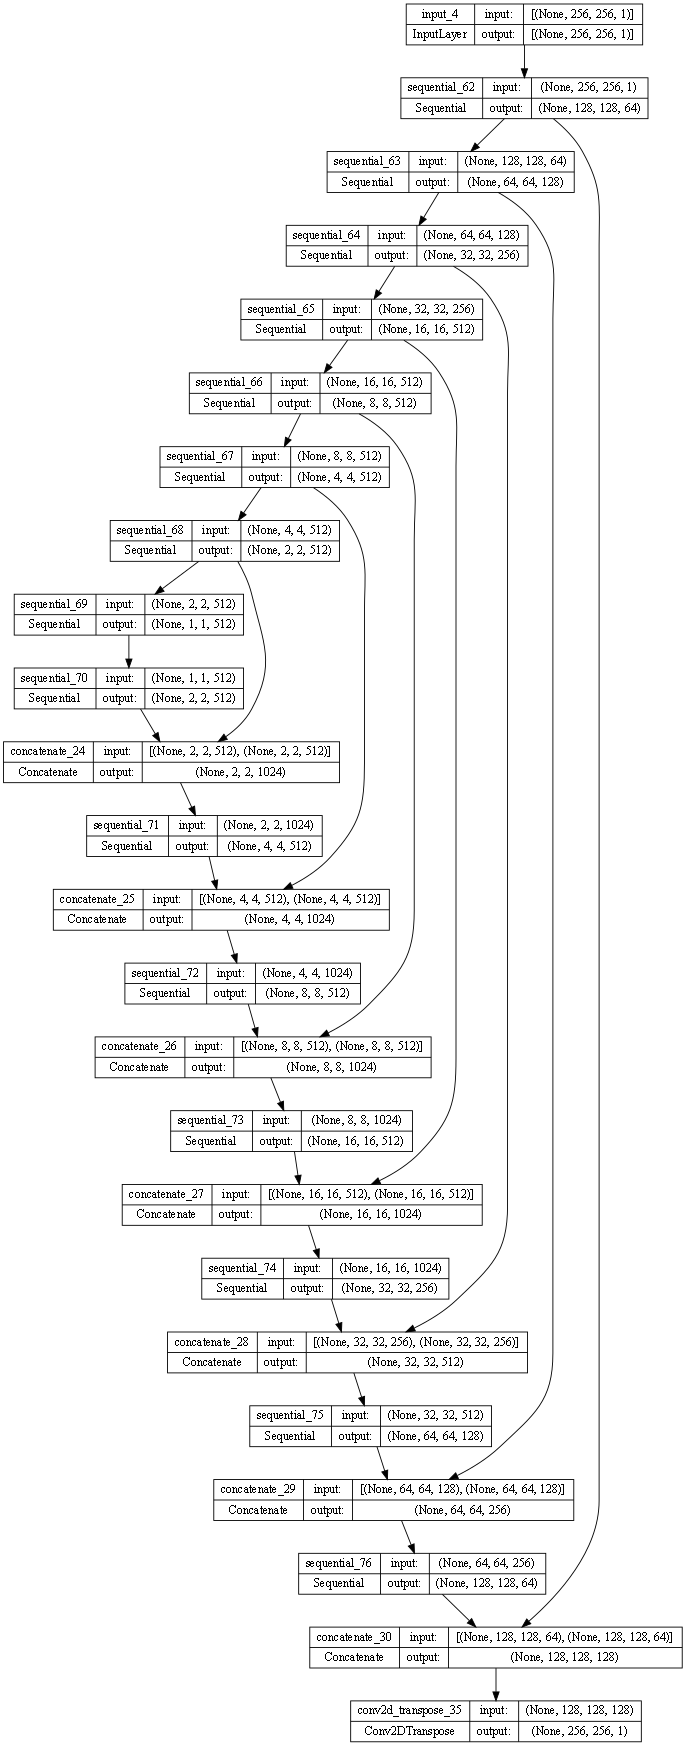

In [158]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [159]:
generator.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_62 (Sequential)     (None, 128, 128, 64  1024        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_63 (Sequential)     (None, 64, 64, 128)  131584      ['sequential_62[0][0]']          
                                                                                            

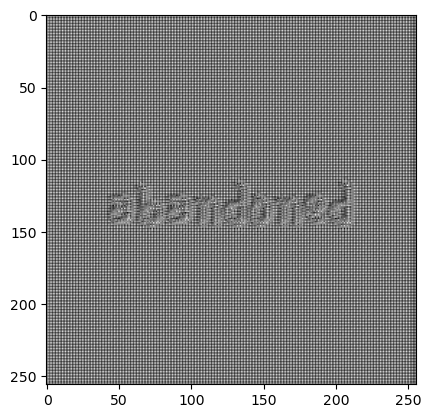

In [160]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...], cmap='gray')

In [161]:
LAMBDA = 100

In [162]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [163]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [164]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, OUTPUT_CHANNELS], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, OUTPUT_CHANNELS], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

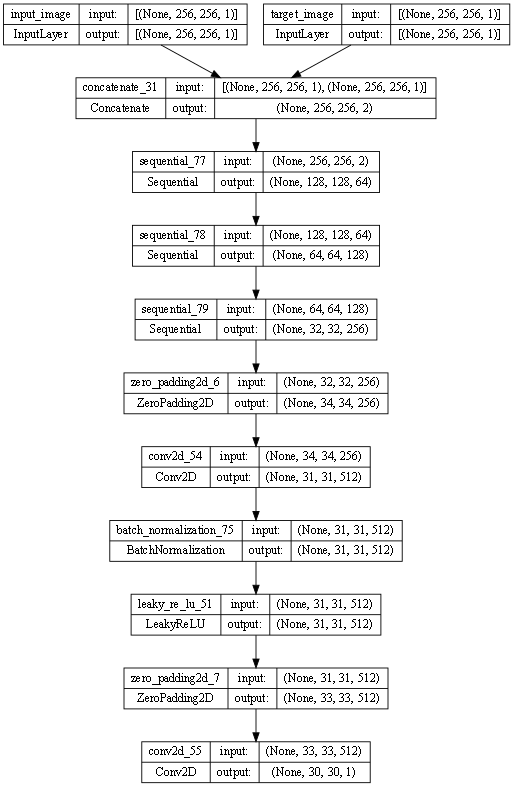

In [165]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [166]:
discriminator.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_31 (Concatenate)   (None, 256, 256, 2)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']     

In [167]:
inp.shape

TensorShape([256, 256, 1])

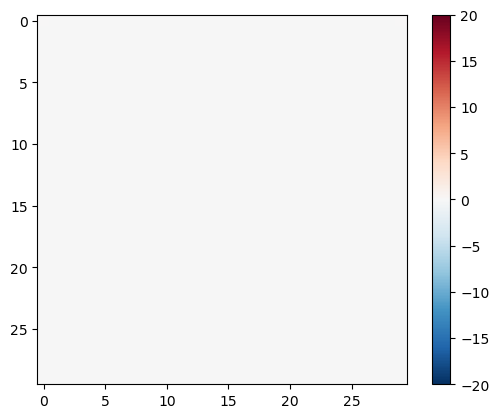

In [168]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [169]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [170]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [171]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5,cmap='gray')
    plt.axis('off')
  plt.show()

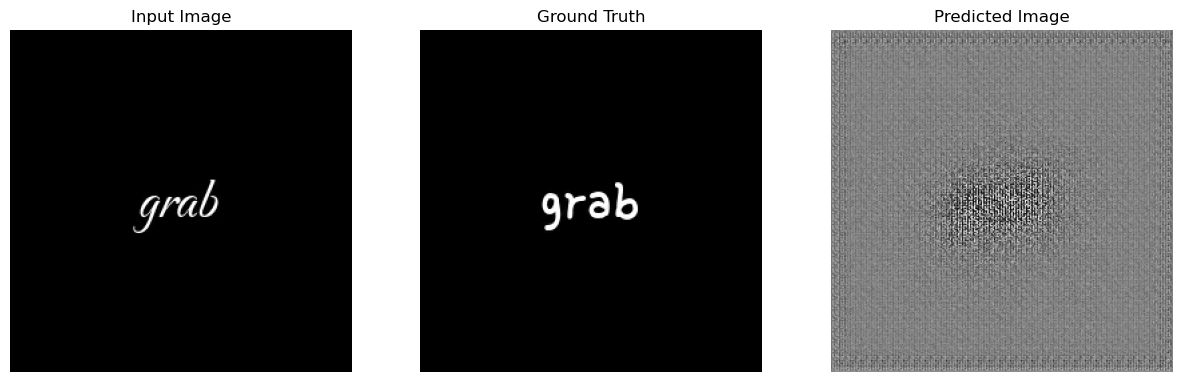

In [172]:
for example_input, example_target in train_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [173]:
log_dir="../logs/"

summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


In [174]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//10)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//10)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//10)
    tf.summary.scalar('disc_loss', disc_loss, step=step//10)

In [175]:
def mod(x,y):
  return x - y * (x // y)

In [176]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if mod(step,10) == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 10 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step}")

    train_step(input_image, target, step)

    # Training step
    if mod(step+1,2) == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    #if (step + 1) % 5000 == 0:
    #  checkpoint.save(file_prefix=checkpoint_prefix)

In [67]:
#%load_ext tensorboard
%reload_ext tensorboard
#%tensorboard --logdir {log_dir}

In [68]:
#%tensorboard --logdir="../logs/fit/"
%tensorboard --logdir {log_dir}

Launching TensorBoard...

In [72]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

Known TensorBoard instances:
  - port 6007: logdir ../logs/fit/ (started 0:00:18 ago; pid 16696)
  - port 6006: logdir ../logs/fit/ (started 20:54:46 ago; pid 16700)
  - port 6006: logdir ../logs/fit (started 21:00:07 ago; pid 1964)
  - port 6006: logdir ../logs/ (started 21:42:52 ago; pid 22464)
  - port 6006: logdir ../logs/fit (started 20:59:23 ago; pid 8424)


In [71]:
notebook.start("--logdir=../logs/fit/ --port 6007")

Launching TensorBoard...

In [73]:
notebook.display(port=6007, height=1000)

Selecting TensorBoard with logdir ../logs/fit/ (started 0:00:23 ago; port 6007, pid 16696).


Time taken for 10 steps: 1.70 sec


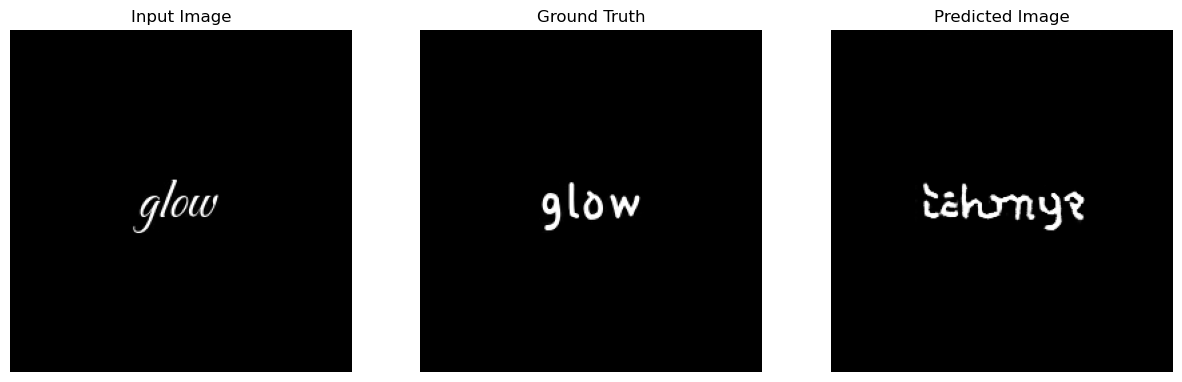

Step: 8010
....

KeyboardInterrupt: 

In [177]:
fit(train_dataset, test_dataset, steps=20000)

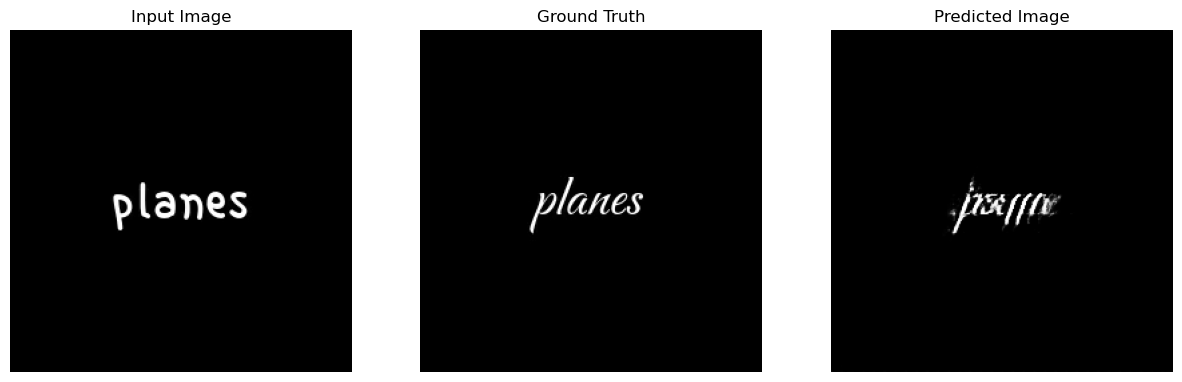

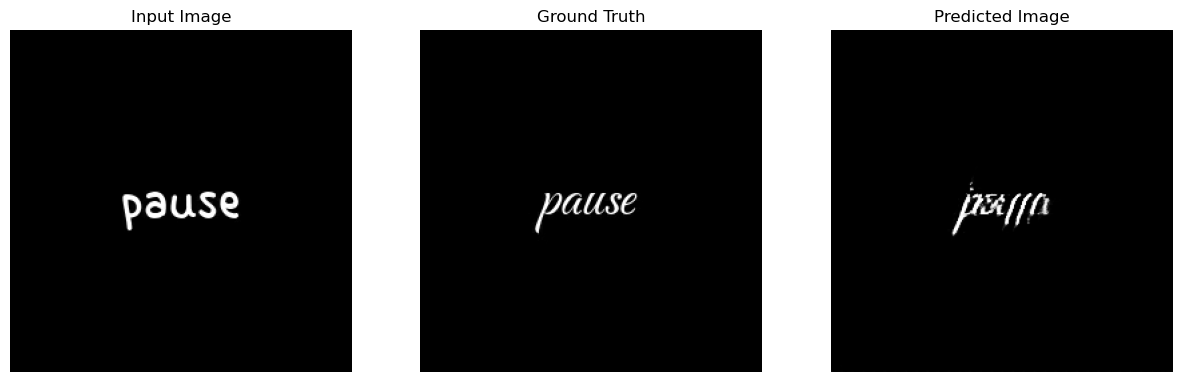

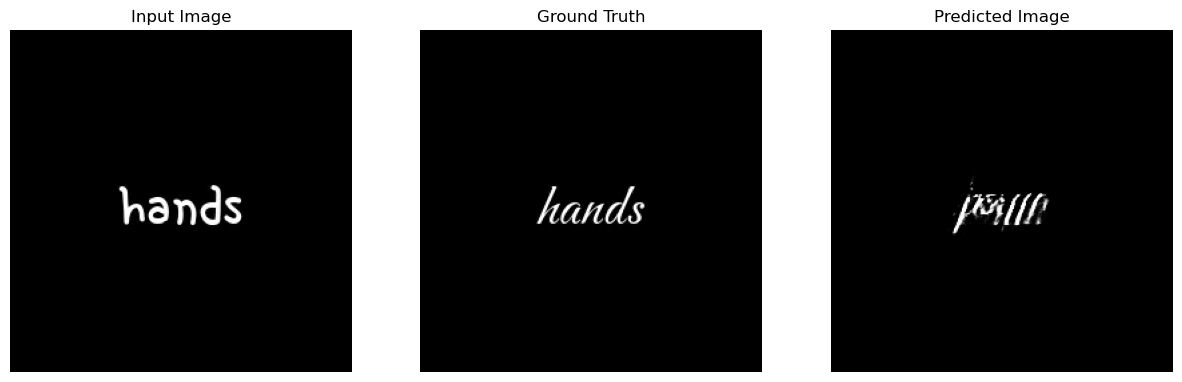

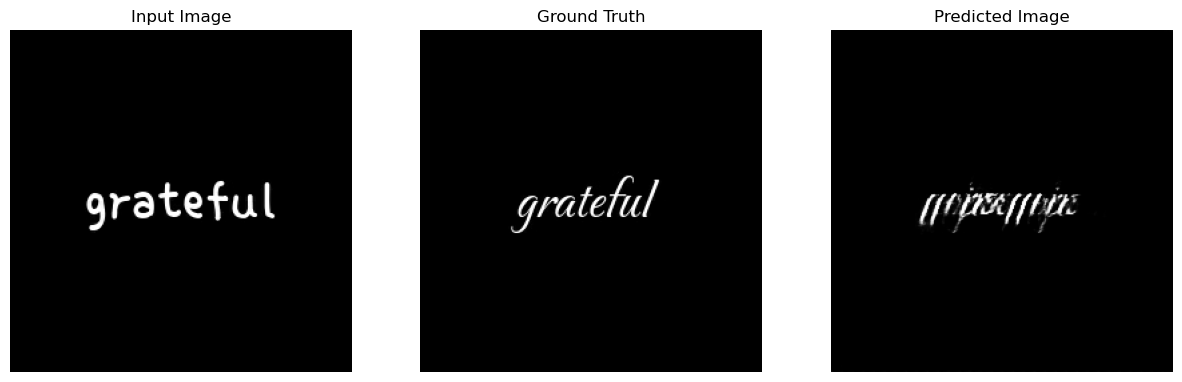

In [112]:
# Run the trained model on a few examples from the test set
for inp, tar in train_dataset.take(4):
  generate_images(generator, inp, tar)